In [1]:
import pandas as pd
import numpy as np

import sys
import re
import os
project_path = os.getcwd()

# 建模

## 读入数据

In [128]:
df_model =pd.read_excel(project_path +'/data/result/df_model_data_importance.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [130]:
discrete_col=['gender','吸烟史','谷胱甘肽','异甘草酸镁','托烷司琼','甘草酸苷','多烯磷脂酰','长春新碱']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('bmd_label')

## 数据归一化

In [131]:
# 防止不同维特征数据差距过大，影响建模效果
for i in continuous_col:
    max_value = df_model[i].max()
    df_model[i]=df_model[i].apply(lambda x: round(x/max_value,3))

In [132]:
df_model.columns

Index(['bmd_label', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '托烷司琼', '长春新碱', '谷胱甘肽',
       '谷丙转氨酶(干式)', 'MTX_tdm_72h', '红细胞', 'gender', '碱性磷酸酶(干式)', '红细胞分布宽度',
       'age', '多烯磷脂酰', '总胆红素(干式)', 'RBC平均容量', 'RBC平均血红量', 'γ-谷氨酰酶(干式)',
       'MTX_tdm_24h', '嗜碱性细胞绝对值', '血清钾(干式)', '肌酐(干式)', 'MTX_tdm_48h',
       'RBC血红浓度', '日剂量', '吸烟史', '血清钠(干式)'],
      dtype='object')

## 插补数据

In [133]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)
        # 列出参数列表
        tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
        # 进行参数的搜索组合
        grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_grid_parameter,cv=3)
        #rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
        #根据已有数据去拟合随机森林模型
        grid.fit(x, y)
        rfr = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'])
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [134]:
# 插补建模数据
df_model_cb=missing_value_interpolation(df_model)

In [8]:
# 保存插补数据
writer = pd.ExcelWriter(project_path + '/data/result/df_model_data_插补.xlsx')
df_model_cb.to_excel(writer)
writer.save()

## 相关性检测

In [218]:
#  连续变量，spearmanr相关性检验(统计量r);
print('--------------------------计算连续变量的spearmanr相关性系数---------------------------------')
from scipy import stats
t_list = []
p_list = []
q_list = []

for i in continuous_col:
    # 删除连续变量中的<、>号
    df_model_cb[i] = df_model_cb[i].astype('str').apply(lambda x: re.sub(r'<|>', '',x))
    x= df_model_cb[df_model_cb[i].astype('float').notnull()][i]
    y= df_model_cb[df_model_cb[i].astype('float').notnull()]['bmd_label']
    t, p = stats.spearmanr(x,y)
    t = round(t, 2)
    p = round(p, 3)
    q = '斯皮尔曼'
    # print(i, t, p)

    t_list.append(t)
    p_list.append(p)
    q_list.append(q)
df_spearmanr= pd.DataFrame(data={'连续检测指标': continuous_col,
                                't值': t_list,
                                'p值': p_list,
                                '方法': q_list})
df_spearmanr_1 = df_spearmanr[df_spearmanr['p值'] <= 0.05]
df_spearmanr_2 = df_spearmanr[df_spearmanr['p值'] >= 0.05]  # 显著性不成立
df_spearmanr = pd.concat([df_spearmanr_1,df_spearmanr_2], axis=0)

df_spearmanr=df_spearmanr.sort_values(by=['p值'],ascending=False)
df_spearmanr = df_spearmanr.reset_index(drop=True)

writer = pd.ExcelWriter(project_path + '/data/result/df_temp_spearmanr相关性检测.xlsx')
df_spearmanr.to_excel(writer)
writer.save()

--------------------------计算连续变量的spearmanr相关性系数---------------------------------


## 划分数据集

In [135]:
from auto_ml.utils_models import load_ml_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [136]:
from auto_ml import Predictor
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['bmd_label'],axis=1)
y = df_model_cb['bmd_label']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=5)


In [137]:
tran_x.shape

(574, 27)

In [138]:
# tran_x.corr()[tran_x.corr()>0.5].to_excel('corr.xlsx')

## 训练集过采样

In [139]:
# 进行过采样
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

## 训练模型

In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score 
feature_list=[]
model_name=[]
precision_list=[]
recall_list=[]
f1_list=[]
# for i in range(df_feature.shape[0]):
#     feature=df_feature.loc[i,'feature_names']
#     col=feature.split('\'')
#     col_list=col[1:-1:2]
#     x_forward=x[col_list]
#     y = df_model_cb['bmd_label']
#     tran_x, test_x, tran_y, test_y = train_test_split(x_forward, y, test_size=0.2, random_state=5)

#     # 进行过采样
#     from imblearn.over_sampling import SMOTE
#     sm = SMOTE(random_state=0)
#     tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)
# 直接使用xgboost和catboost包，而不是auto_ml
import xgboost
import lightgbm
import catboost
from sklearn import metrics
from sklearn.metrics import r2_score,precision_score,classification_report,confusion_matrix,roc_auc_score,average_precision_score,precision_recall_curve
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=300,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('xgb',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('xgb')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# LightGBM模型
xgb_model=lightgbm.LGBMClassifier(iterations=300, learning_rate=0.1, loss_function='precision',random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('lgbm',precision,recall,f1)
feature_list.append(feature_list)
model_name.append('LGBM')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# CatBoost模型
xgb_model=catboost.CatBoostClassifier(iterations=300, learning_rate=0.01, loss_function='CrossEntropy',random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
feature_list.append(feature_list)
print('catboost',precision,recall,f1)
model_name.append('catboost')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'])
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('rf',precision,recall,f1)
feature_list.append(feature_list)
model_name.append('RF')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = GradientBoostingClassifier(n_estimators=grid.best_params_['n_estimators'])
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('gbdt',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('GBDT')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr = SVC(kernel='linear', C=1.25)
svr.fit(tran_x_sm,tran_y_sm)
predictions=svr.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('SVC',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('SVR')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv = LogisticRegression()
# lcv = Lasso()
# lcv = Ridge()
lcv.fit(tran_x_sm, tran_y_sm)
predictions = lcv.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('lr',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('lr')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# ANN
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.008, 
                    hidden_layer_sizes=[100,], 
                    solver='lbfgs', 
                    activation='relu', 
                    random_state=0)
ANN.fit(tran_x_sm, tran_y_sm)
predictions=ANN.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('ann',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('ann')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=5)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_valid.to_numpy(), tran_y_valid.to_numpy())], 
        eval_name=['train'],
        eval_metric=['auc'],
        max_epochs=100, 
        patience=200,
        batch_size=50,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)
predictions=TabNet_model.predict(test_x.to_numpy())
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('tab',precision,recall,f1)

feature_list.append(feature_list)
model_name.append('TabNet')
precision_list.append(round(precision,3))
recall_list.append(round(recall,3))
f1_list.append(round(f1,3))

xgb 0.7222222222222222 0.9285714285714286 0.8125000000000001
lgbm 0.8181818181818182 0.6428571428571429 0.7200000000000001
0:	learn: 0.6789622	total: 22.4ms	remaining: 6.71s
1:	learn: 0.6669959	total: 42.3ms	remaining: 6.3s
2:	learn: 0.6537112	total: 61.3ms	remaining: 6.07s
3:	learn: 0.6409085	total: 78.1ms	remaining: 5.78s
4:	learn: 0.6301404	total: 93.8ms	remaining: 5.54s
5:	learn: 0.6174887	total: 110ms	remaining: 5.39s
6:	learn: 0.6078158	total: 121ms	remaining: 5.05s
7:	learn: 0.5966240	total: 136ms	remaining: 4.97s
8:	learn: 0.5854775	total: 149ms	remaining: 4.81s
9:	learn: 0.5746688	total: 162ms	remaining: 4.7s
10:	learn: 0.5656783	total: 173ms	remaining: 4.53s
11:	learn: 0.5554815	total: 185ms	remaining: 4.45s
12:	learn: 0.5465086	total: 201ms	remaining: 4.43s
13:	learn: 0.5367645	total: 217ms	remaining: 4.43s
14:	learn: 0.5274392	total: 230ms	remaining: 4.37s
15:	learn: 0.5200255	total: 241ms	remaining: 4.28s
16:	learn: 0.5105656	total: 257ms	remaining: 4.28s
17:	learn: 0.5029

167:	learn: 0.1632512	total: 2.65s	remaining: 2.08s
168:	learn: 0.1625206	total: 2.67s	remaining: 2.07s
169:	learn: 0.1619673	total: 2.69s	remaining: 2.05s
170:	learn: 0.1609709	total: 2.7s	remaining: 2.04s
171:	learn: 0.1601378	total: 2.72s	remaining: 2.02s
172:	learn: 0.1595794	total: 2.74s	remaining: 2.01s
173:	learn: 0.1590300	total: 2.75s	remaining: 1.99s
174:	learn: 0.1586741	total: 2.77s	remaining: 1.98s
175:	learn: 0.1580235	total: 2.78s	remaining: 1.96s
176:	learn: 0.1575374	total: 2.8s	remaining: 1.94s
177:	learn: 0.1570733	total: 2.81s	remaining: 1.93s
178:	learn: 0.1564528	total: 2.83s	remaining: 1.91s
179:	learn: 0.1556976	total: 2.85s	remaining: 1.9s
180:	learn: 0.1551741	total: 2.87s	remaining: 1.88s
181:	learn: 0.1545893	total: 2.88s	remaining: 1.87s
182:	learn: 0.1541463	total: 2.9s	remaining: 1.85s
183:	learn: 0.1533785	total: 2.92s	remaining: 1.84s
184:	learn: 0.1527808	total: 2.93s	remaining: 1.82s
185:	learn: 0.1523459	total: 2.95s	remaining: 1.81s
186:	learn: 0.15

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ann 0.55 0.7857142857142857 0.6470588235294117
Device used : cpu
epoch 0  | loss: 0.68455 | train_auc: 0.86905 |  0:00:00s
epoch 1  | loss: 0.58288 | train_auc: 0.92752 |  0:00:00s
epoch 2  | loss: 0.49453 | train_auc: 0.94398 |  0:00:01s
epoch 3  | loss: 0.43052 | train_auc: 0.93592 |  0:00:01s
epoch 4  | loss: 0.37278 | train_auc: 0.95308 |  0:00:01s
epoch 5  | loss: 0.33936 | train_auc: 0.93627 |  0:00:02s
epoch 6  | loss: 0.33476 | train_auc: 0.93627 |  0:00:02s
epoch 7  | loss: 0.34142 | train_auc: 0.96043 |  0:00:03s
epoch 8  | loss: 0.30574 | train_auc: 0.92927 |  0:00:03s
epoch 9  | loss: 0.30922 | train_auc: 0.93697 |  0:00:04s
epoch 10 | loss: 0.28147 | train_auc: 0.94713 |  0:00:04s
epoch 11 | loss: 0.3029  | train_auc: 0.95063 |  0:00:04s
epoch 12 | loss: 0.27735 | train_auc: 0.96043 |  0:00:05s
epoch 13 | loss: 0.26993 | train_auc: 0.96254 |  0:00:05s
epoch 14 | loss: 0.26396 | train_auc: 0.95798 |  0:00:06s
epoch 15 | loss: 0.23251 | train_auc: 0.95658 |  0:00:06s
epoch 1

In [26]:
f1_list

[0.813, 0.72, 0.733, 0.815, 0.741, 0.737, 0.722, 0.647, 0.743]

In [23]:
df_model_result=pd.DataFrame(data={'model':model_name,
                                  'precision':precision_list,
                                  'recall':recall_list,
                                  'f1':f1_list})

In [24]:
df_model_result

,model,precision,recall,f1
0,xgb,0.722,0.929,0.813
1,LGBM,0.818,0.643,0.720
2,catboost,0.688,0.786,0.733
3,RF,0.846,0.786,0.815
4,GBDT,0.769,0.714,0.741
5,SVR,0.583,1.000,0.737
6,lr,0.591,0.929,0.722
7,ann,0.550,0.786,0.647
8,TabNet,0.619,0.929,0.743


In [25]:
# 保存模型测试效果
df_model_result.to_excel(project_path+'/data/result/df_模型测试效果.xlsx')

### xgboost

In [14]:
# 直接使用xgboost和catboost包，而不是auto_ml
import xgboost
import lightgbm
import catboost
from sklearn import metrics
from sklearn.metrics import r2_score,precision_score,classification_report,confusion_matrix,roc_auc_score,average_precision_score,precision_recall_curve
# XGBoost模型
xgb_model=xgboost.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=300,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1)

# LightGBM模型
# xgb_model=lightgbm.LGBMClassifier(iterations=300, learning_rate=0.1, loss_function='precision',random_state=3)
# CatBoost模型
# xgb_model=catboost.CatBoostClassifier(iterations=300, learning_rate=0.01, loss_function='CrossEntropy',random_state=3)
xgb_model.fit(tran_x_sm,tran_y_sm)
predictions=xgb_model.predict(test_x)
xgb_fpr, xgb_tpr, thresholds = metrics.roc_curve(test_y, predictions, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
xgb_auc=roc_auc_score(test_y,predictions)

xgb_ap = average_precision_score(test_y, predictions)
xgb_precision, xgb_recall, _ = precision_recall_curve(test_y, predictions)
# print(predictions)
print(classification_report(test_y, xgb_model.predict(test_x)))
cm2_LogR_model = confusion_matrix(test_y, xgb_model.predict(test_x))
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       130
           1       0.72      0.93      0.81        14

    accuracy                           0.96       144
   macro avg       0.86      0.95      0.89       144
weighted avg       0.97      0.96      0.96       144

[[125   5]
 [  1  13]]


In [15]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Random Forest

In [61]:
# 随机森林，GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
# 进行参数的搜索组合
grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'])
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)

rf_fpr, rf_tpr, thresholds = metrics.roc_curve(test_y, predictions, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
rf_auc=roc_auc_score(test_y,predictions)

rf_ap = average_precision_score(test_y, predictions)
rf_precision, rf_recall, _ = precision_recall_curve(test_y, predictions)


precision:  0.65
recall:  0.9285714285714286
f1:  0.7647058823529412


### GBDT

In [74]:
# GBDT
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# 列出参数列表
tree_grid_parameter = {'n_estimators': [50, 100, 150,200,300,500],
                      'learning_rate': [0.01,0.1,0.2],
                      'max_depth': [3,5],
                      'subsample':[0.5,0.6,0.7,0.8]}
# 进行参数的搜索组合
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=tree_grid_parameter, cv=3)
# 根据已有数据去拟合随机森林模型
grid.fit(tran_x_sm, tran_y_sm)
rfr = GradientBoostingClassifier(n_estimators=grid.best_params_['n_estimators'],
                            learning_rate=grid.best_params_['learning_rate'],
                            max_depth=grid.best_params_['max_depth'],
                            subsample=grid.best_params_['subsample'])
rfr.fit(tran_x_sm, tran_y_sm)
# 预测缺失值
predictions = rfr.predict(test_x)
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('rf',precision,recall,f1)

rf 0.7857142857142857 0.7857142857142857 0.7857142857142857


In [75]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.7}

### SVR

In [30]:
# SVR
from sklearn.svm import SVR,SVC
# 回归模型
# svr = SVR(kernel='linear', C=1.25)
# 分类模型
svr = SVC(kernel='linear', C=1.25)
svr.fit(tran_x_sm,tran_y_sm)
predictions=svr.predict(test_x)

### KNN

In [267]:
# KNN训练
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(tran_x,tran_y)
predictions=knn.predict(test_x)

### linear model

In [28]:
# Linear回归，Lasso回归，领回归
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,LogisticRegression
lcv = LogisticRegression()
# lcv = Lasso()
# lcv = Ridge()

lcv.fit(tran_x_sm, tran_y_sm)
predictions = lcv.predict(test_x)
logistic_fpr, logistic_tpr, thresholds = metrics.roc_curve(test_y, predictions, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
logistic_auc=roc_auc_score(test_y,predictions)

logistic_ap = average_precision_score(test_y, predictions)
logistic_precision, logistic_recall, _ = precision_recall_curve(test_y, predictions)

### ANN

In [482]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ann_params = {'alpha': [0.0001,0.001,0.01,0.1,1],
              "solver": ['adam', 'sgd', 'lbfgs'],
              'hidden_layer_sizes': [(100,), (50,), (20,), (10,), (5,),]}

ANN = MLPClassifier()
grid = GridSearchCV(ANN, 
                    ann_params, 
                    cv=5, 
                    scoring='f1'
                   )
grid.fit(tran_x_sm, tran_y_sm)
# print(predictions)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic 

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic 

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [494]:
grid.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ANN = MLPClassifier(alpha=0.008, 
                    hidden_layer_sizes=[100,], 
                    solver='lbfgs', 
                    activation='relu', 
                    random_state=0)
ANN.fit(tran_x_sm, tran_y_sm)
predictions=ANN.predict(test_x)
ann_fpr, ann_tpr, thresholds = metrics.roc_curve(test_y, predictions, pos_label=1)  #pos_label=2，表示值为2的实际值为正样本
ann_auc=roc_auc_score(test_y,predictions)

ann_ap = average_precision_score(test_y, predictions)
ann_precision, ann_recall, _ = precision_recall_curve(test_y, predictions)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [503]:
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       130
           1       0.83      0.71      0.77        14

    accuracy                           0.96       144
   macro avg       0.90      0.85      0.87       144
weighted avg       0.96      0.96      0.96       144

[[128   2]
 [  4  10]]


### TabNet

In [34]:
import ctypes
os.chdir('D:\Anaconda3\Lib\site-packages\~-rch\lib')
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

<CDLL 'caffe2_nvrtc.dll', handle 7ff8a4dd0000 at 0x174be377f60>

In [77]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
TabNet_model = TabNetClassifier()  #TabNetRegressor()
tran_x_x, tran_x_valid, tran_y_y, tran_y_valid = train_test_split(tran_x_sm, tran_y_sm, test_size=0.1, random_state=5)

TabNet_model.fit(X_train=tran_x_x.to_numpy(),  
        y_train=tran_y_y.to_numpy(), 
        eval_set=[(tran_x_x.to_numpy(), tran_y_y.to_numpy())], 
        eval_name=['train'], 
        eval_metric=['auc'],
        max_epochs=100, 
        patience=200,
        batch_size=50,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False)
predictions=TabNet_model.predict(test_x.to_numpy())
precision = precision_score(test_y,predictions)
recall=recall_score(test_y,predictions)
f1=f1_score(test_y,predictions)
print('tab',precision,recall,f1)


Device used : cpu
epoch 0  | loss: 0.68455 | train_auc: 0.91397 |  0:00:00s
epoch 1  | loss: 0.58288 | train_auc: 0.94242 |  0:00:01s
epoch 2  | loss: 0.49453 | train_auc: 0.95392 |  0:00:01s
epoch 3  | loss: 0.43052 | train_auc: 0.94656 |  0:00:02s
epoch 4  | loss: 0.37278 | train_auc: 0.95464 |  0:00:02s
epoch 5  | loss: 0.33936 | train_auc: 0.95349 |  0:00:03s
epoch 6  | loss: 0.33476 | train_auc: 0.94938 |  0:00:03s
epoch 7  | loss: 0.34142 | train_auc: 0.94921 |  0:00:04s
epoch 8  | loss: 0.30574 | train_auc: 0.93812 |  0:00:04s
epoch 9  | loss: 0.30922 | train_auc: 0.96488 |  0:00:05s
epoch 10 | loss: 0.28147 | train_auc: 0.96404 |  0:00:05s
epoch 11 | loss: 0.3029  | train_auc: 0.96958 |  0:00:06s
epoch 12 | loss: 0.27735 | train_auc: 0.97092 |  0:00:06s
epoch 13 | loss: 0.26993 | train_auc: 0.96415 |  0:00:07s
epoch 14 | loss: 0.26396 | train_auc: 0.97071 |  0:00:07s
epoch 15 | loss: 0.23251 | train_auc: 0.97792 |  0:00:07s
epoch 16 | loss: 0.22938 | train_auc: 0.98026 |  0:00:

In [18]:
predictions=TabNet_model.predict(test_x.to_numpy())
print(classification_report(test_y, predictions))

cm2_LogR_model = confusion_matrix(test_y, predictions)
print(cm2_LogR_model) #混肴矩阵

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       130
           1       0.64      1.00      0.78        14

    accuracy                           0.94       144
   macro avg       0.82      0.97      0.87       144
weighted avg       0.96      0.94      0.95       144

[[122   8]
 [  0  14]]


## 计算评价指标

In [15]:
# 计算R2和均方误差MSE
print('-----------------------计算R2和均方误差MSE---------------------------')

from sklearn.metrics import mean_squared_error  # 均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
from sklearn.metrics import precision_score,recall_score,f1_score  # R square
# 调用

r2 = precision_score(test_y,predictions)
print('precision: ',r2)
mse=recall_score(test_y,predictions)
print('recall: ',mse)
mae=f1_score(test_y,predictions)
print('f1: ',mae)

-----------------------计算R2和均方误差MSE---------------------------
precision:  0.7222222222222222
recall:  0.9285714285714286
f1:  0.8125000000000001


In [306]:
test_y.shape

(144,)

In [19]:
df_predictions= pd.DataFrame(data={'真实值':test_y,'预测值':predictions})
writer = pd.ExcelWriter(project_path + '/data/result/df_model_测试集结果.xlsx')
df_predictions.to_excel(writer)
writer.save()

## 画图

### 重要性评分

In [27]:
# 重要性
import catboost,xgboost
model_boost=xgboost.XGBClassifier(max_depth=5,
                                learning_rate=0.01,
                                n_estimators=500,
                                min_child_weight=0.5,
                                eta=0.1,
                                gamma=0.5,
                                reg_lambda=10,
                                subsample=0.5,
                                colsample_bytree=0.8,
                                nthread=4,
                                scale_pos_weight=1)
model_boost.fit(tran_x_sm,tran_y_sm)
importance = model_boost.feature_importances_
print(tran_x_sm.columns)
print(importance)

Index(['异甘草酸镁', '甘草酸苷', '托烷司琼', '谷胱甘肽', '红细胞', '碱性磷酸酶(干式)', 'age', '多烯磷脂酰',
       '总胆红素(干式)', 'γ-谷氨酰酶(干式)', '血清钾(干式)', 'RBC血红浓度', '吸烟史', '血清钠(干式)'],
      dtype='object')
[0.32401422 0.16513763 0.13240813 0.11942993 0.03339625 0.03247426
 0.0167521  0.04207282 0.022382   0.0336325  0.02501285 0.02221035
 0.01525009 0.0158269 ]


In [28]:
df_importance= pd.DataFrame(data={'特征':tran_x.columns,'重要性评分':importance})
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))
df_importance=df_importance.sort_values(['重要性评分'],ascending=False)
df_importance=df_importance.reset_index(drop=True)

In [29]:
writer = pd.ExcelWriter(project_path + '/data/result/df_模型重要性评分.xlsx')
df_importance.to_excel(writer)
writer.save()

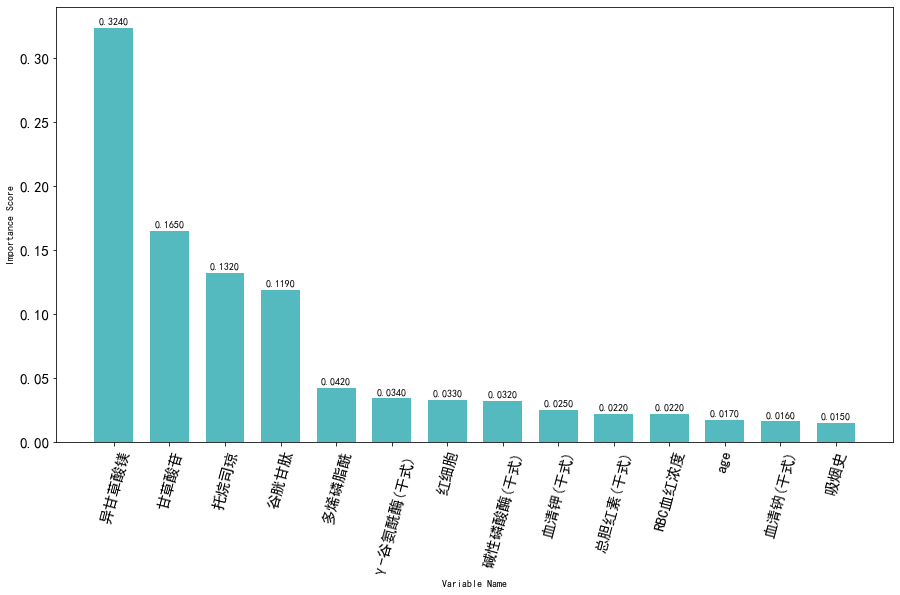

In [58]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

names = df_importance['特征']
index = np.arange(len(names))
plt.figure(figsize=(15, 8))
plt.bar(df_importance['特征'], df_importance['重要性评分'], width=0.7,
        color=(0.32941176470588235, 0.7294117647058823, 0.7490196078431373), tick_label=names)
plt.xticks(rotation=75)
# 设置坐标刻度值的大小
plt.tick_params(labelsize=15)

plt.ylabel('Importance Score')
plt.xlabel('Variable Name')
for a, b in zip(index, df_importance['重要性评分']):
    plt.text(a, b + 0.002, '%.4f' % b, ha='center', va='bottom', fontsize=10)
# plt.title('重要变量得分柱形图')
# plt.show()

### 散点图

In [51]:
# 判断文件路径是否存在，如果不存在则创建该路径
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:  # 判断是否存在文件夹如果不存在则创建为文件夹
        os.makedirs(path)  # makedirs 创建文件时如果路径不存在会创建这个路径

In [ ]:
# 画图
print('-----------------------画图---------------------------')
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# 散点图
# axis设置坐标轴的范围
# plt.axis([-20, 20, 0, 200])
# x为x轴中坐标x的值，y为y轴中坐标y的值，x与y都是长度相同的数组序列，color为点的颜色，marker为散点的形状，
# 折线图刻度调小，要不然点都堆到一块了
ax = plt.gca()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
# plt.scatter(range(len(test_y)),test_y,c='r')
plt.scatter(test_y,predictions,c='b')
# 红色参照线
plt.plot(list(range(test_y.shape[0])), list(range(test_y.shape[0])),color='r')
# plt.plot(list(range(30)), list(range(30)),color='r')
plt.xlabel('Number of Events(unit)')
plt.ylabel('MTX Bone Suppression')

In [52]:
# plt.show()
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/他克莫司血药浓度测试集散点图v2.0.jpg", dpi=300)
plt.clf()  # 删除前面所画的图

-----------------------画图---------------------------


<Figure size 432x288 with 0 Axes>

### AUC曲线

In [22]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

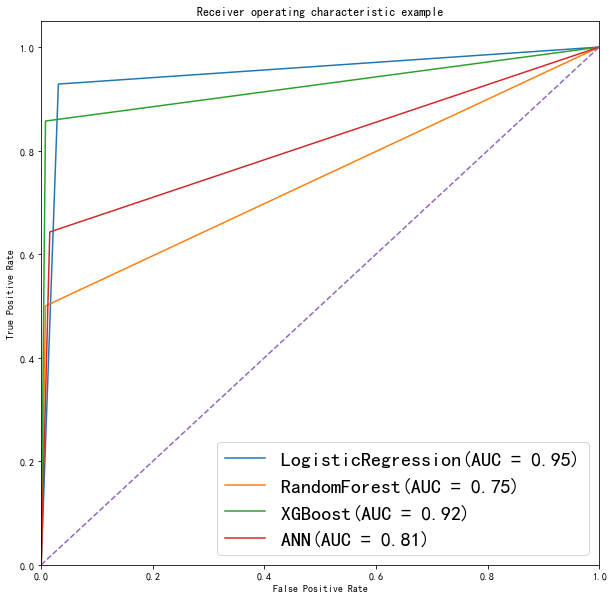

In [36]:
plt.figure(figsize=(10,10))

plt.plot(logistic_fpr, logistic_tpr,label='LogisticRegression(AUC = %0.2f)' % logistic_auc) 
plt.plot(rf_fpr, rf_tpr,label='RandomForest(AUC = %0.2f)' % rf_auc) 
plt.plot(xgb_fpr, xgb_tpr,label='XGBoost(AUC = %0.2f)' % xgb_auc) 
plt.plot(ann_fpr, ann_tpr,label='ANN(AUC = %0.2f)' % ann_auc) 

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve of MTX drug')
plt.legend(loc="lower right", fontsize=20)
plt.show()

### precision曲线

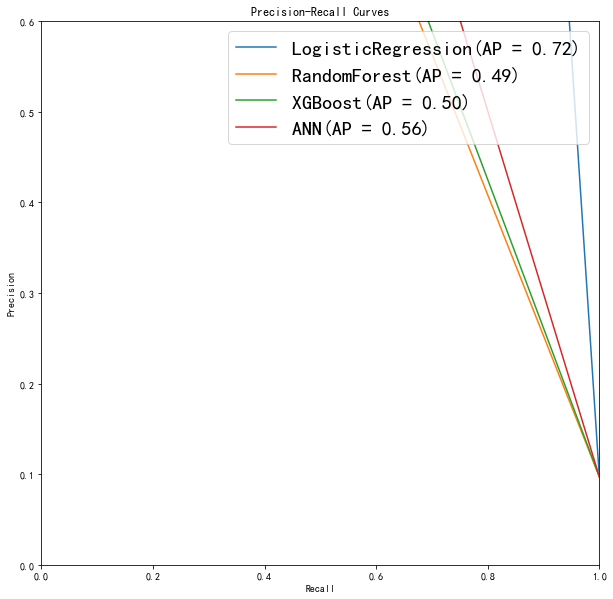

In [57]:
plt.figure(figsize=(10,10))

plt.plot(logistic_recall, logistic_precision, label='LogisticRegression(AP = %0.2f)' % logistic_ap)
plt.plot(rf_recall, rf_precision,label='RandomForest(AP = %0.2f)' % rf_ap) 
plt.plot(xgb_recall, xgb_precision,label='XGBoost(AP = %0.2f)' % xgb_ap) 
plt.plot(ann_recall, ann_precision,label='ANN(AP = %0.2f)' % ann_ap) 
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.6])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right", fontsize=20)
plt.show()

### SHAP图

In [43]:
?shap.summary_plot

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


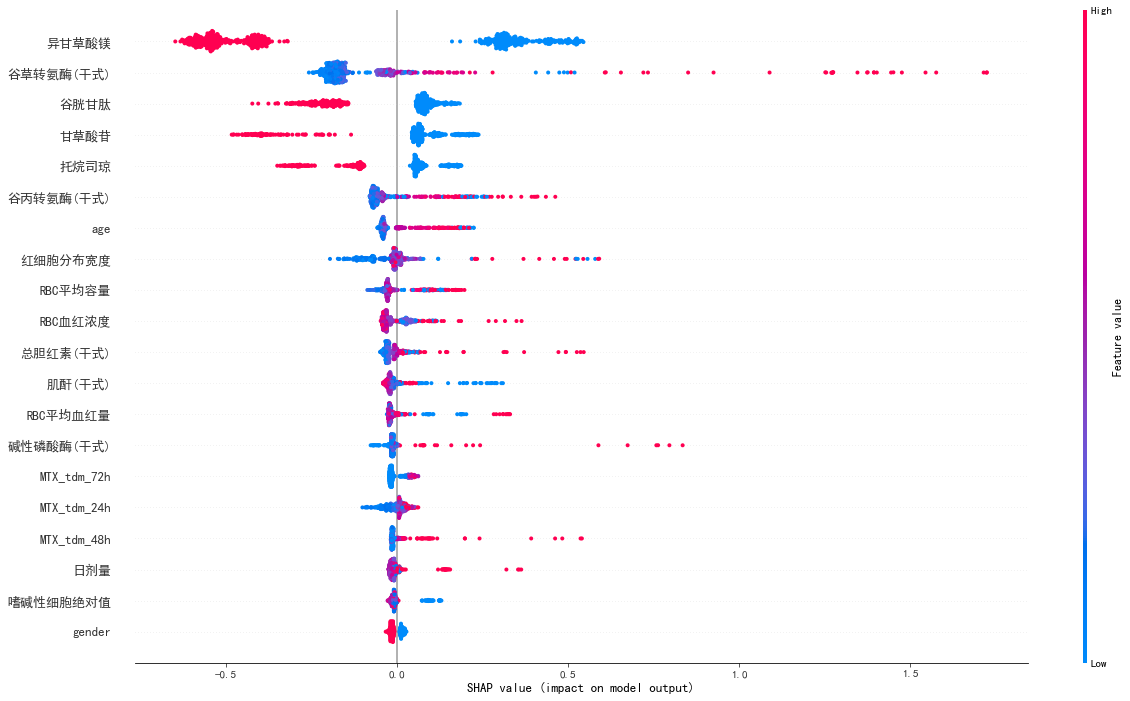

In [147]:
# SHAP图
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('mathtext', default='regular')

import xgboost as xgb
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
shap_model = xgb.XGBClassifier(max_depth=5,
                        learning_rate=0.01,
                        n_estimators=500,
                        min_child_weight=0.5,
                        eta=0.1,
                        gamma=0.5,
                        reg_lambda=10,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        nthread=4,
                        scale_pos_weight=1)
shap_model.fit(tran_x, tran_y)

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(tran_x)  # 传入特征矩阵X，计算SHAP值
# print(shap_values)
# summarize the effects of all the features
shap.summary_plot(shap_values, tran_x, plot_size=(20,12))

In [148]:
# 保存各个变量的shape值的和
df_shap_values=pd.DataFrame(shap_values)
shap_list=[]
shap_pos_list=[]
patient_pos_list=[]
shap_neg_list=[]
patient_neg_list=[]

for j in range(df_shap_values.shape[1]):
    temp=df_shap_values.iloc[:,j]
    df_temp=pd.DataFrame(data={'values':temp})
    # 正shap值
    df_shap_pos=df_temp[df_temp['values']>=0]
    shap_pos_list.append(df_shap_pos.values.sum())
    # 正shap患者数
    patient_pos_list.append(df_shap_pos.shape[0])
    # 负shap值
    df_shap_neg=df_temp[df_temp['values']<0]
    shap_neg_list.append(df_shap_neg.values.sum())
    # 负sahp患者数
    patient_neg_list.append(df_shap_neg.shape[0])
    # shap和
    shap_sum = temp.sum()
    shap_sum = round(shap_sum, 2)
    shap_list.append(shap_sum)

df_shap = pd.DataFrame({'features':list(tran_x.columns),
                        'shap值':shap_list,
                        '正患者数':patient_pos_list,
                       'shap_pos':shap_pos_list,
                        '负患者数':patient_neg_list,
                       'shap_neg':shap_neg_list})
df_shap = df_shap.sort_values(by=['shap值'], ascending=False)
df_shap = df_shap.reset_index(drop=True)

In [149]:
df_shap_values

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.493114,0.013439,0.212330,0.161205,-0.017556,0.127539,-0.066257,-0.018847,0.035362,0.023770,...,0.007541,-0.026841,-0.004471,0.007767,-0.002491,-0.011834,0.051021,-0.006103,0.0,0.000336
1,-0.465787,-0.204204,0.057564,-0.128542,0.002040,0.081842,-0.074861,-0.015492,0.023511,-0.013714,...,0.000296,0.020651,-0.007464,0.125231,-0.023509,-0.015810,-0.031778,0.005809,0.0,-0.005455
2,0.333714,-0.009154,0.113778,-0.262280,0.002901,-0.279201,-0.040720,-0.016642,0.002133,-0.016595,...,-0.004984,-0.034450,-0.010802,0.002106,0.001951,-0.010774,-0.032060,-0.010410,0.0,-0.004721
3,0.361266,-0.226927,0.129515,-0.337756,0.004688,0.087664,-0.070344,0.009610,-0.003264,-0.021443,...,0.002200,-0.004920,-0.008501,0.001250,-0.019360,-0.017627,-0.024562,-0.019865,0.0,-0.001508
4,-0.385250,-0.162730,0.044208,-0.098532,0.001598,-0.142825,-0.016146,-0.012490,-0.002583,-0.007621,...,0.005418,-0.022117,-0.001664,-0.017059,-0.026260,-0.013795,0.020640,-0.019700,0.0,-0.004067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,-0.547174,0.519316,0.064741,0.055347,0.002658,-0.197009,0.254998,-0.011823,-0.007559,-0.006645,...,-0.006296,0.025902,-0.004314,-0.002442,-0.021549,-0.012578,0.015023,-0.013855,0.0,-0.001509
570,-0.383122,-0.161732,0.049291,-0.106437,0.001931,-0.191388,-0.042469,-0.014820,-0.007851,0.014002,...,-0.002495,-0.009965,-0.009123,-0.002402,0.087126,-0.011996,-0.033185,-0.001849,0.0,-0.002297
571,-0.502401,-0.162989,0.058127,0.050063,0.002189,-0.214503,-0.059646,0.030141,0.003770,0.011629,...,-0.002717,-0.030359,0.075569,0.016345,0.083354,-0.010346,0.012017,-0.002183,0.0,-0.001201
572,-0.410083,-0.185747,0.052042,-0.125258,0.002029,0.080268,-0.071100,0.036042,-0.019607,-0.015195,...,-0.004088,0.018902,-0.017878,-0.025403,-0.020374,0.006123,0.017941,-0.017112,0.0,-0.003338


In [150]:
writer = pd.ExcelWriter(project_path + '/data/result/df_27变量_shap值排序.xlsx')
df_shap.to_excel(writer)
writer.save()